Current Time = 09:29:40
key = CPU

************************************************************
use_gpu = 0, use_hash=0

************************************************************
rho theta


2022-01-03:09:29:40, INFO     [AZernike.py:0457] CPU Available RAM: 16.619163648 GB


rho shape = (4000000,)
img shape=  (512, 512)
img shape=  (2000, 2000)
************************************************************
K = 2.0, T = 5

************************************************************
use_gpu = 0, use_hash=0

************************************************************
rho theta


2022-01-03:09:29:49, INFO     [AZernike.py:0457] CPU Available RAM: 16.43425792 GB


rho shape = (9000000,)
img shape=  (512, 512)
img shape=  (3000, 3000)
************************************************************
K = 3.0, T = 5

************************************************************
use_gpu = 0, use_hash=0

************************************************************
rho theta


2022-01-03:09:30:10, INFO     [AZernike.py:0457] CPU Available RAM: 16.158130176 GB


rho shape = (16000000,)
img shape=  (512, 512)
img shape=  (4000, 4000)
************************************************************
K = 4.0, T = 5

************************************************************
use_gpu = 0, use_hash=0

************************************************************
rho theta


2022-01-03:09:30:46, INFO     [AZernike.py:0457] CPU Available RAM: 15.786344448 GB


rho shape = (25000000,)
img shape=  (512, 512)
img shape=  (5000, 5000)
************************************************************
K = 5.0, T = 5
key = GPU

************************************************************
use_gpu = 1, use_hash=0

************************************************************
rho theta


2022-01-03:09:31:39, INFO     [AZernike.py:0478] GPU Available RAM: 2.08 GB


rho shape = (4000000,)
img shape=  (512, 512)
img shape=  (2000, 2000)
************************************************************
K = 2.0, T = 5


2022-01-03:09:31:40, INFO     [AZernike.py:0478] GPU Available RAM: 2.08 GB



************************************************************
use_gpu = 1, use_hash=0

************************************************************
rho theta
rho shape = (9000000,)
img shape=  (512, 512)
img shape=  (3000, 3000)
************************************************************
K = 3.0, T = 5


2022-01-03:09:31:40, INFO     [AZernike.py:0478] GPU Available RAM: 2.08 GB



************************************************************
use_gpu = 1, use_hash=0

************************************************************
rho theta
rho shape = (16000000,)
img shape=  (512, 512)
img shape=  (4000, 4000)
************************************************************
K = 4.0, T = 5


2022-01-03:09:31:42, INFO     [AZernike.py:0478] GPU Available RAM: 2.08 GB



************************************************************
use_gpu = 1, use_hash=0

************************************************************
rho theta
rho shape = (25000000,)
img shape=  (512, 512)
img shape=  (5000, 5000)
************************************************************
K = 5.0, T = 5

Plotting .... 


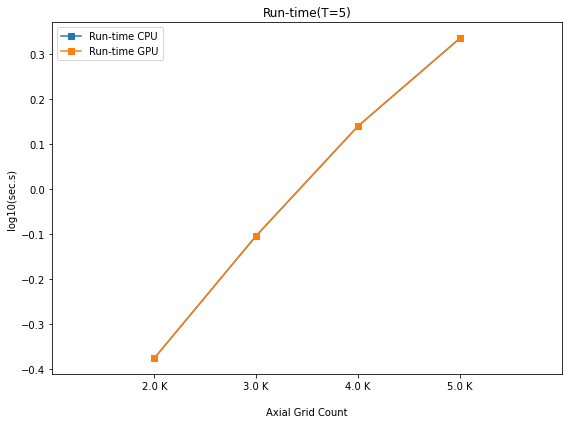


Done.
Wall time: 2min 4s


In [22]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 차수에 따른 연산 속도 

print_curr_time()

line = "*"*60
line2 = "\n" + line

img_infos = []
    
Ks = numpy.arange( 2, 5.1, 1 ) 

datas = { }

for use_gpu in [0, 1] : 
    options = {}
    options[ "debug" ] = 0 
    options[ "use_gpu" ] = use_gpu
    options[ "hash" ] = {}
    options[ "use_hash" ] = 0 
    options[ "use_thread"] = 0 
    
    device = "GPU" if options["use_gpu"] else "CPU"
    multi = "Multi " if options["use_thread"] else ""
    
    key = f"{multi}{device}"
    print( f"key = {key}")
    run_times = []
    data = {}
    data[ "Ks"] = Ks
    data[ "run_times" ] = run_times
    datas[ key ] = data 
    
    for K in Ks : 
        options[ "hash" ] = {}
        
        print( line2 )
        print( f"use_gpu = { options['use_gpu'] }, use_hash={ options['use_hash'] }" )

        print( line2 )
        print( "rho theta")

        circle_type = "outer" 

        rho, theta, x, y, dx, dy, k = rho_theta( 1000*K, circle_type, **options ) 

        print( f"rho shape = {rho.shape}" )

        img = cv.imread( 'image/lenna.png', 0 )

        print( "img shape= ", img.shape )

        img_org = img 

        np = cupy if options['use_gpu'] else numpy

        img = cv.resize( img_org, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )

        if options['use_gpu']  : 
            img = np.array( img )
        pass

        img_org = img

        print( "img shape= ", img.shape )

        print( line )

        T_MAX = 25 

        max_mem = max_gpu_memory() if options['use_gpu']  else max_cpu_memory() 

        if max_mem < 8 :
            T_MAX = 18
        elif max_mem < 25 :
            T_MAX = 20
        pass

        T_MAX = 5 

        T = T_MAX
        print( f"K = {K}, T = {T}" )

        moments, run_time = calc_moments(T, img, rho, theta, dx, dy, **options )
        
        run_times.append( run_time ) 
        
        del options[ "hash" ]
    pass
pass

print( "\nPlotting .... ")
    
# 서브 챠트 생성 
row_cnt = 1
col_cnt = 1

fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(8*col_cnt, 6*row_cnt) )
charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
chart_idx = 0 
chart = charts[ chart_idx ] ; chart_idx += 1
chart.set_title( f"Run-time(T={T})" ) 

for key in datas : 
    data = datas[ key ]
    
    Ks = data[ "Ks" ]
    run_time = data[ "run_times" ]
    
    x = Ks
    y = numpy.log10( run_times ) 
    
    label = f"Run-time {key}"    
    chart.plot( x, y, marker="s", label=label )
    chart.set_xlabel( "\nAxial Grid Count" )
    chart.set_ylabel( "log10(sec.s)")
    chart.set_xticks( x )
    chart.set_xticklabels( [ f"{k} K" for k in x ] )
    chart.set_xlim( numpy.min(x) -1, numpy.max(x) + 1 )

    chart.legend()
pass

plt.tight_layout(); plt.show() 

del options

print( "\nDone." )
